<a href="https://colab.research.google.com/github/OBB-2199/EscapeEarth/blob/main/Interns/Olivia/EBremoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## mount google drive to access files

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## typical imports
%matplotlib inline
!pip install lightkurve==1.9.0 #b/c non-standard library & we want a specific version
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs

     |████████████████████████████████| 501kB 10.7MB/s 
     |████████████████████████████████| 3.9MB 24.3MB/s 
     |████████████████████████████████| 256kB 54.2MB/s 
     |████████████████████████████████| 808kB 52.9MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 3.2MB 55.4MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp37-none-any.whl size=11376 sha256=4884da86280949b7867480a322bc736767c0f37d2dfacbf24f5373f7347655b9
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for oktopus: filename=oktopus-0.1.2-cp37-none-any.whl size=12780 sha256=3a6c029319e1de8d6dbe12223ad7ebf8e16cccf5e64870a89c1d228152e70583
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for pyvo: filename=pyvo-1.1-cp37-none-any.whl size=801573 sha256=62cf27f9a174b5b99ddb61f072d222299bb719231954a9cdf37561b6a7da8a0f
  Stor

In [ ]:
#trying to see our sample size evolution
#load datafiles
main = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/main_df.csv') #bls stats from 14 & 15
targets14 = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/all_targets_S014_v1.csv',skiprows = 5)
targets15 = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/all_targets_S015_v1.csv',skiprows= 5)
final_candidates = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/final_candidates.csv')
#manipulate dfs
alltargets = pd.concat([targets14,targets15]) #all lightcurves (even for duplicate targets)
dupetargets = pd.merge(targets14,targets15,on='TICID') #targets observed in both sectors
unqs = alltargets['TICID'].unique() #all unique targets
print('number of targets observed in Sectors 14 & 15:',len(dupetargets))
print('number of targets observed in only one Sector (14 or 15):',len(unqs) - len(dupetargets))
print('Total number of unique targets:',len(unqs))
print('total number of data files (light curves):',len(alltargets))
#get temps for tempcut
catalog_data = Catalogs.query_criteria(catalog='Tic', ID = unqs) 
catalog_df = catalog_data.to_pandas()
sample_start = catalog_df #unique targets b/c fed in unqs list
sample_tempcut = catalog_df[catalog_df['Teff']<6500] #unique targets b/c fed in unqs list
#merge with main to get bls cut after teff cut
catalog_df['ID'] = catalog_df['ID'].astype(int) #change str to match int in alltargets
merged = pd.merge(alltargets, catalog_df, left_on ='TICID',right_on='ID') #give all lcs a temp
merged2 = merged[merged['Teff']<6500] #redo temp cut 
sanitycheck_temp = merged2['TICID'].unique() #this should match sample_tempcut
print('these should match:',len(sample_tempcut),len(sanitycheck_temp),'otherwise check tempcut')
merged3 = pd.merge(merged2,main, left_on='TICID',right_on='TIC') #give tempcut bls stats
#bls cut
bls_cut1 = merged3['Power']>50 
bls_cut2 = merged3['Duration']<0.125
blscut = merged3[(bls_cut1) & (bls_cut2)] #includes multiple observations of same star
sample_blscut = blscut['TIC'].unique() #get unique targets only b/c will be transits in both observed sectors
#giant removal
sample_final = final_candidates['ID'].unique() #this is from mast so unique by nature
#final number of light curves
mask = np.isin(main['TIC'].to_numpy(), sample_final)
lc_end = main[mask]
#make variable names more meaningful
lc_start = alltargets
lc_end = lc_end
#make these equal to dataframes so temp is accessible
start_df = catalog_df
tempcut_df = sample_tempcut
blscut_df = Catalogs.query_criteria(catalog='Tic', ID = sample_blscut) #need to add temps
final_df = Catalogs.query_criteria(catalog='Tic', ID = sample_final) #need to add temps
print('\nEvolution of sample reduction:')
print('starting:', len(sample_start),'\ntempcut:',len(sample_tempcut),'\nblscut:',len(sample_blscut),'\nfinal:',len(sample_final))
print('\nStarted with {} light curves and reduced to {} lightcurves'.format(len(lc_start),len(lc_end)))
print('Started with {} unique targets and reduced to {} exoplanet hosting candidate targets'.format(len(sample_start),len(sample_final)))

number of targets observed in Sectors 14 & 15: 12094
number of targets observed in only one Sector (14 or 15): 15812
Total number of unique targets: 27906
total number of data files (light curves): 40000
these should match: 22789 22789 otherwise check tempcut

Evolution of sample reduction:
starting: 27906 
tempcut: 22789 
blscut: 244 
final: 149

Started with 40000 light curves and reduced to 221 lightcurves
Started with 27906 unique targets and reduced to 149 exoplanet hosting candidate targets


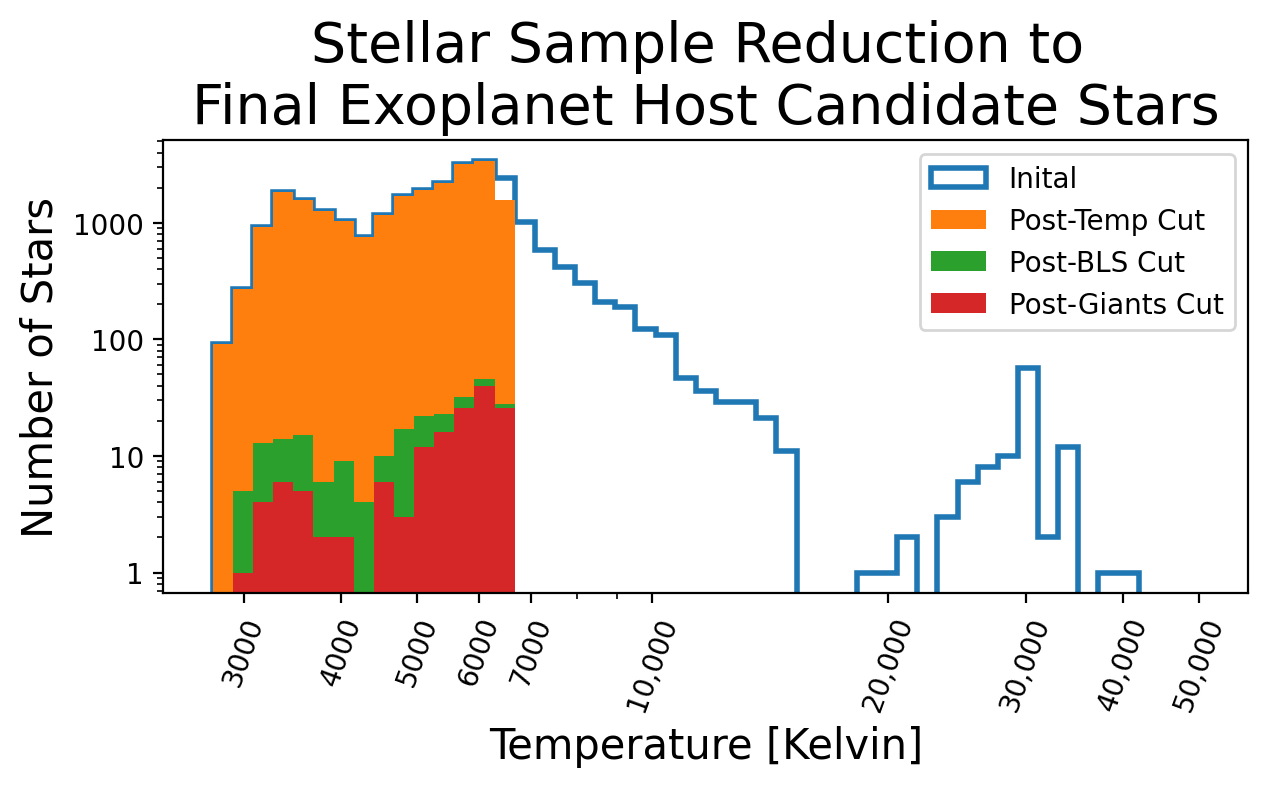

In [ ]:
#histogram of sample reduction
%matplotlib inline
start_temps = start_df['Teff'].to_numpy()
tempcut_temps = tempcut_df['Teff'].to_numpy()
blscut_temps = blscut_df['Teff'] #.to_numpy()
final_temps = final_df['Teff'] #.to_numpy()
#info needed for iterating to make plot
myarrs = [start_temps, tempcut_temps, blscut_temps, final_temps]
bins1=np.logspace(np.log10(min(start_temps)),np.log10(max(start_temps)), 50)
bins2=np.logspace(np.log10(2700),np.log10(7000), 50)
names =['Inital','Post-Temp Cut','Post-BLS Cut','Post-Giants Cut']
plt.figure(figsize=(7,3),dpi=200)
for count,arr in enumerate(myarrs):
  if count ==0:
    plt.hist(arr,bins=bins1,label=names[count],histtype='step',lw=2) #makes easier to see behind all other data
  else:
    plt.hist(arr,bins=bins1,label=names[count],histtype ='stepfilled')
# plt.xlim(7000, 2000) #if want in usual cmd view
plt.legend();plt.xscale('log');plt.yscale('log')
#change ticks for readability 
plt.yticks(ticks=([1, 10, 100, 1000]),
           labels=['1', '10', '100', '1000'])
plt.xticks(ticks=([3E3, 4E3, 5E3, 6E3,7E3, 1E4, 2E4,3E4,4E4,5E4]),
           labels=['3000', '4000', '5000', '6000','7000','10,000','20,000','30,000','40,000','50,000'],rotation=70)
plt.ylabel('Number of Stars',fontsize=15); plt.xlabel('Temperature [Kelvin]',fontsize=15)
plt.title('Stellar Sample Reduction to \nFinal Exoplanet Host Candidate Stars',fontsize=20);

In [ ]:
#planet radii calculation fcn
def planet_radii(depth, star_radius):
    import math as m
    R_Sun = 696340000 #m
    R_Earth = 6371000 #m
    r_star = star_radius * R_Sun #b/c in R_Sun units
    radius = r_star * m.sqrt(depth) 
    r_planet = radius / R_Earth #b/c need in R_Earth
    return r_planet

In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/EscapeEarthData/')
import LCAnalysis_test as lca

In [ ]:
candidates = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/final_candidates.csv')
candidates

,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,...,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,ABS Mag
0,26584043,20190415,NaN,3551-00183-1,695-066800,19281062+4856369,NaN,J192810.61+485636.0,2129722038386345472,54443748.0,11244501.0,STAR,tmgaia2,292.044285,48.943530,tmgaia2,-8.63573,0.045241,-66.23690,0.043199,gaia2,9.44595,0.023352,gaia2,80.884833,14.509196,313.629043,69.067209,10.646,0.065,9.935,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.004684,0.001545,0.002819,panstarrs,0.121205,0.129359,0.039780,0.092235,0.143803,0.218956,0.070150,0.103765,0.026203,0.023051,0.2620,0.2620,bj2018,147.7530,139.740,spect,10.27840,0.005166,9.28557,0.004795,1,NaN,tycho2v3,tycho2b3,NaN,0.770690,0.670026,292.044228,48.943245,0.019350,0.024440,1,0,288792450,4.718098
1,26656583,20190415,NaN,3564-01688-1,698-069158,19301822+4931325,NaN,J193018.24+493133.2,2129813469650632064,54446097.0,11560447.0,STAR,tmgaia2,292.575961,49.525712,tmgaia2,15.61760,0.053184,62.78720,0.046020,gaia2,7.93962,0.031862,gaia2,81.581227,14.439999,315.216611,69.445791,11.679,0.139,11.096,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.002801,0.003669,0.003956,panstarrs,0.097937,0.146821,0.057792,0.040721,0.470629,0.383539,0.090284,0.076151,0.017125,0.014185,0.5040,0.5080,bj2018,93.1649,192.239,spect,11.29630,0.018626,10.26440,0.016484,1,NaN,tycho2v3,tycho2b3,NaN,0.908227,0.713839,292.576065,49.525983,0.026720,0.027550,1,0,293647317,5.329599
2,27843942,20190415,NaN,NaN,707-065798,19454606+5113275,NaN,J194546.06+511327.4,2135488770715834496,55728891.0,12418816.0,STAR,tmgaia2,296.441888,51.224299,tmgaia2,6.46022,0.045214,-2.69806,0.043673,gaia2,4.13598,0.023822,gaia2,84.270443,12.978797,323.763711,69.772709,13.715,0.025,12.779,0.080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000843,0.004042,0.002750,panstarrs,0.060676,0.108071,0.094729,0.094678,0.100550,0.122906,0.101573,0.090373,0.017759,0.039043,1.3760,1.3920,bj2018,104.0680,139.194,spect,13.00080,0.003844,11.77430,0.002877,1,NaN,ucac4,apassdr9,NaN,0.777445,0.677344,296.441933,51.224287,0.019893,0.023543,1,0,334931959,5.537392
3,27915909,20190415,NaN,3561-00922-1,693-071357,19471820+4826361,NaN,J194718.22+482636.1,2086643104093265792,54466249.0,10987439.0,STAR,tmgaia2,296.825880,48.443339,tmgaia2,12.23340,0.059813,4.96015,0.060169,gaia2,2.67200,0.031236,gaia2,81.871846,11.462243,320.649452,67.223843,11.314,0.109,10.689,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000969,0.010003,0.015610,panstarrs,0.198998,0.228531,0.089318,0.128627,0.052317,0.057282,0.097923,0.104853,0.323779,0.293419,4.2670,4.3660,bj2018,175.3610,148.135,spect,11.02350,0.000878,10.33890,0.000641,1,NaN,tycho2v3,tycho2b3,NaN,1.016970,0.933177,296.825959,48.443360,0.027646,0.032123,1,0,338972385,2.882082
4,28230919,20190415,97657.0,3561-02092-1,691-070316,19505021+4804508,NaN,NaN,2086512227851023872,54470133.0,10748390.0,STAR,tmgaia2,297.709364,48.080860,tmgaia2,125.98400,0.040610,232.98800,0.044990,gaia2,26.45080,0.023446,gaia2,81.833703,10.772381,321.548036,66.629442,10.556,0.141,9.460,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.010943,0.000000,0.000000,NaN,0.075780,0.099804,0.051426,0.045157,0.418599,0.455017,0.080525,0.092496,0.009814,0.008251,0.0336,0.0337,bj2018,107.3600,118.373,spect,9.74374,0.001652,8.46507,0.001891,1,NaN,hipvmag,apassdr9,NaN,0.689515,0.697757,297.710176,48.081864,0.019271,0.024141,1,0,347873767,6.263174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#open bls results to merge with candiate df
bls_results = pd.read_csv('/content/gdrive/My Drive/EscapeEarthData/main_df.csv')

# merge dataframe
df = pd.merge(candidates,bls_results, left_on = 'ID', right_on='TIC')
df


,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,...,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,ABS Mag,TIC,Period,Duration,Transit Time,Power,Depth,Sector
0,26584043,20190415,NaN,3551-00183-1,695-066800,19281062+4856369,NaN,J192810.61+485636.0,2129722038386345472,54443748.0,11244501.0,STAR,tmgaia2,292.044285,48.943530,tmgaia2,-8.63573,0.045241,-66.23690,0.043199,gaia2,9.44595,0.023352,gaia2,80.884833,14.509196,313.629043,69.067209,10.646,0.065,9.935,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039780,0.092235,0.143803,0.218956,0.070150,0.103765,0.026203,0.023051,0.2620,0.2620,bj2018,147.7530,139.740,spect,10.27840,0.005166,9.28557,0.004795,1,NaN,tycho2v3,tycho2b3,NaN,0.770690,0.670026,292.044228,48.943245,0.019350,0.024440,1,0,288792450,4.718098,26584043,0.445693,0.074,0.400,88,0.003599,14
1,26584043,20190415,NaN,3551-00183-1,695-066800,19281062+4856369,NaN,J192810.61+485636.0,2129722038386345472,54443748.0,11244501.0,STAR,tmgaia2,292.044285,48.943530,tmgaia2,-8.63573,0.045241,-66.23690,0.043199,gaia2,9.44595,0.023352,gaia2,80.884833,14.509196,313.629043,69.067209,10.646,0.065,9.935,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039780,0.092235,0.143803,0.218956,0.070150,0.103765,0.026203,0.023051,0.2620,0.2620,bj2018,147.7530,139.740,spect,10.27840,0.005166,9.28557,0.004795,1,NaN,tycho2v3,tycho2b3,NaN,0.770690,0.670026,292.044228,48.943245,0.019350,0.024440,1,0,288792450,4.718098,26584043,0.445693,0.074,0.278,88,0.003714,15
2,26656583,20190415,NaN,3564-01688-1,698-069158,19301822+4931325,NaN,J193018.24+493133.2,2129813469650632064,54446097.0,11560447.0,STAR,tmgaia2,292.575961,49.525712,tmgaia2,15.61760,0.053184,62.78720,0.046020,gaia2,7.93962,0.031862,gaia2,81.581227,14.439999,315.216611,69.445791,11.679,0.139,11.096,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.057792,0.040721,0.470629,0.383539,0.090284,0.076151,0.017125,0.014185,0.5040,0.5080,bj2018,93.1649,192.239,spect,11.29630,0.018626,10.26440,0.016484,1,NaN,tycho2v3,tycho2b3,NaN,0.908227,0.713839,292.576065,49.525983,0.026720,0.027550,1,0,293647317,5.329599,26656583,0.528840,0.074,0.501,126,0.138116,14
3,26656583,20190415,NaN,3564-01688-1,698-069158,19301822+4931325,NaN,J193018.24+493133.2,2129813469650632064,54446097.0,11560447.0,STAR,tmgaia2,292.575961,49.525712,tmgaia2,15.61760,0.053184,62.78720,0.046020,gaia2,7.93962,0.031862,gaia2,81.581227,14.439999,315.216611,69.445791,11.679,0.139,11.096,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.057792,0.040721,0.470629,0.383539,0.090284,0.076151,0.017125,0.014185,0.5040,0.5080,bj2018,93.1649,192.239,spect,11.29630,0.018626,10.26440,0.016484,1,NaN,tycho2v3,tycho2b3,NaN,0.908227,0.713839,292.576065,49.525983,0.026720,0.027550,1,0,293647317,5.329599,26656583,0.528840,0.074,0.466,126,0.142436,15
4,27843942,20190415,NaN,NaN,707-065798,19454606+5113275,NaN,J194546.06+511327.4,2135488770715834496,55728891.0,12418816.0,STAR,tmgaia2,296.441888,51.224299,tmgaia2,6.46022,0.045214,-2.69806,0.043673,gaia2,4.13598,0.023822,gaia2,84.270443,12.978797,323.763711,69.772709,13.715,0.025,12.779,0.080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.094729,0.094678,0.100550,0.122906,0.101573,0.090373,0.017759,0.039043,1.3760,1.3920,bj2018,104.0680,139.194,spect,13.00080,0.003844,11.77430,0.002877,1,NaN,ucac4,apassdr9,NaN,0.777445,0.677344,296.441933,51.224287,0.019893,0.023543,1,0,334931959,5.537392,27843942,0.761510,0.074,0.722,207,0.203324,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# #put into custom class

# tic = 445859771
# sector = 14
# mydata = [tic,sector]

# starclass = lca.LCAnalysis(mydata)
# starclass

In [ ]:
olivia = df.iloc[0:31]#[145:158
# olivia

In [ ]:
count = 10

tics = olivia['TIC'].to_numpy() #all targets
tic = tics[count]#target I'm looking at

sector = 14
mydata = [tic,sector]

starclass = lca.LCAnalysis(mydata) #initate class
starclass #verify its a class object now

TIC: 41998476

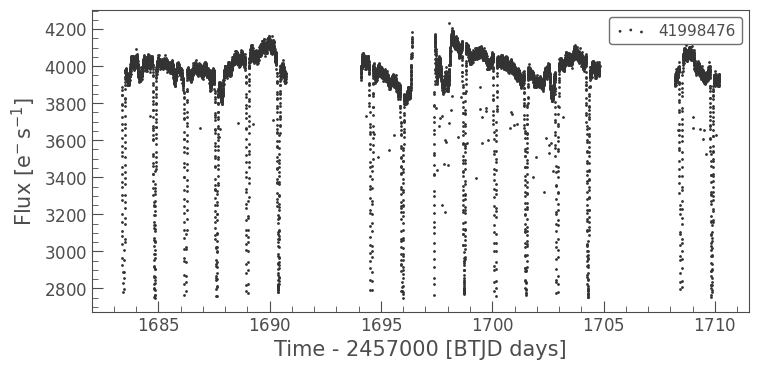

In [ ]:
%matplotlib inline
lc = starclass.open_clean_lc()
lc.scatter()

10    0.167365
11    0.081822
Name: Depth, dtype: float64
estimated planet radius:  66.41184174890616


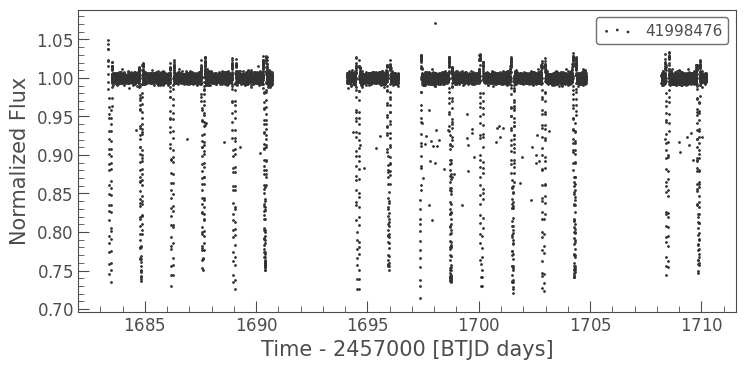

In [ ]:
#estimate depth by eye

lcnorm = lc.normalize()
lcflat = lcnorm.flatten()
target_df = olivia[olivia['TIC']==tic]
bls_depth = target_df['Depth'].to_numpy()[0]
star_r = target_df['rad'].to_numpy()[0]
print(target_df['Depth'])
est_radius = planet_radii(bls_depth, star_r)
print('estimated planet radius: ', est_radius)
lcflat.scatter()

1.3920012960709829


[]

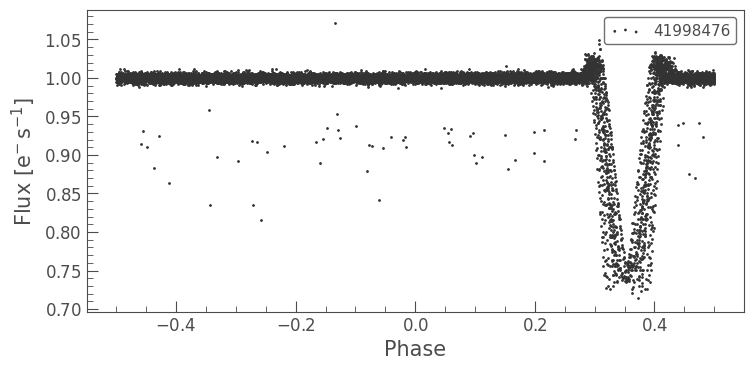

In [ ]:
period = olivia['Period'].iloc[count]
print(period)
folded_lc = starclass.folded(period)
folded_lc.plot()